# Ptan intro

[PTAN](https://github.com/Shmuma/ptan) (abbrevation of `PyTorch AgentNet`) is a small library I wrote to simplify RL experiments. It tries to keep the balance between two extremes:

1. import lib, then write one line to train the DQN (very vivid example is [OpenAI baselines project](https://github.com/openai/baselines/))
2. implement everything from scratch

First approach is very inflexible. It works good when you're using the library the way it supposed to be used. But if you want to do something fancy, you quickly find yourself hacking the lib and fighting with constraints imposed by the author rather than solving the problem you want to solve.

Second extreme gives you *too much freedom* and requires implementing replay buffers and trajectory handling over and over again, which is error-prone, boring and inefficient.

Several years ago I was tired of writing replay buffers and decided to implement something in between: not "the universal RL lib", but a set of classes to avoid writing boilerplate code.

I used ptan to implement all the [examples for the "Deep Reinforcement Learning Hands-On" book](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/), which include all the major DRL methods, which includes DQN, A3C, all tricks in Rainbow paper, DDPG, D4PG, PPO, TRPO, Acktr and AlphaGo Zero.

## High-level overview

From the high level, ptan provides you the following entities:

* `Agent`: class which knows how to convert batch of observations to batch of actions to be executed. It can contain optional state, in case you need to track some info between consequent actions in one episode (for example, noise params for Ornstein–Uhlenbeck exploration). Normally, you can use [already existing Agent instances](https://github.com/Shmuma/ptan/blob/master/ptan/agent.py) or write your own subclass of `BaseAgent`.
* `ActionSelector`: small piece of logic which knows how to choose the action from some output of the network. Works in tandem with `Agent` https://github.com/Shmuma/ptan/blob/master/ptan/actions.py
* `ExperienceSource` and variations: by using the `Agent` instance and gym environment object can provide information about the trajectory from episodes. In the simplest form it is one single $(a, r, s')$ transition at a time, but functionality goes beyond this. Source file is https://github.com/Shmuma/ptan/blob/master/ptan/experience.py
* `ExperienceSourceBuffer` and friends: replay buffers with various characteristics. Includes simple replay buffer and two versions of prioritized replay buffers
* various utility classes, like `TargetNet` (both discrete and continuous), wrappers for time-series preprocessing (used for tracking training progress in TensorBoard)
* includes wrappers for Gym environments, for example, wrappers for Atari games (copy-pasted from OpenAI baselines with some tweaks): https://github.com/Shmuma/ptan/blob/master/ptan/common/wrappers.py

And that's basically it. Total amount of sourse is just ~1500 lines of Python, which is almost nothing.

Below I'm going to demonstrate how ptan could be used to simplify RL methods implementation.

# Installation

We'll need gym, opencv python bindings. And pytorch, of course

In [1]:

!pip install gym opencv_python
!pip install ptan


# Imports

In [147]:
import ptan
import gym
import numpy as np
from typing import List, Any, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt

%matplotlib inline

# Action selector

https://github.com/Shmuma/ptan/blob/master/ptan/actions.py

Helps to go from network output to concrete action values. Most common cases:
* Argmax: commonly used by Q-value methods, when the network predicts Q-values for set of actions and the desired action is the action with the largest Q
* Policy-based: network outputs the probability distribution (in form of logits or normalized distribution) and action need to be sampled from this distribution. Used commonly by PG-methods

Action selector is used by the `Agent`, and rarely need to be customized (but you have this option). Concrete classes which could be used:
* [`ArgmaxActionSelector`](https://github.com/Shmuma/ptan/blob/master/ptan/actions.py#L12): applies `argmax` on the second axis of passed tensor (matrix is assumed)
* [`ProbabilityActionSelector`](https://github.com/Shmuma/ptan/blob/master/ptan/actions.py#L36): samples from probability distribution of discrete set of actions
* [`EpsilonGreedyActionSelector`](https://github.com/Shmuma/ptan/blob/master/ptan/actions.py#L21): has parameter $\epsilon$ which specifies the probability of random action to be taken. 

All the classes assume numpy arrays to be passed to them


In [8]:
q_vals = np.array([[1, 2, 3], [1, -1, 0]])
q_vals

array([[ 1,  2,  3],
       [ 1, -1,  0]])

In [9]:
selector = ptan.actions.ArgmaxActionSelector()
selector(q_vals)

array([2, 0])

In [11]:
selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=0.0)
selector(q_vals)
# have to be the same result, as episilon is 0 (no random actions)

array([2, 0])

In [15]:
selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1.0)
selector(q_vals)
# will be random

array([0, 2])

In [17]:
# here we sample from probability distribution (have to be normalized)
selector = ptan.actions.ProbabilityActionSelector()
for _ in range(10):
    acts = selector(np.array([
        [0.1, 0.8, 0.1],
        [0.0, 0.0, 1.0],
        [0.5, 0.5, 0.0]
    ]))
    print(acts)

[1 2 1]
[1 2 0]
[2 2 0]
[1 2 0]
[1 2 0]
[1 2 1]
[1 2 1]
[1 2 0]
[1 2 0]
[1 2 0]


# Agent class

`Agent` is class which knows how to convert observations into actions. There are three most common approaches:
* **Q-function**: NN predicts Q-values for actions, the $argmax Q(s)$ is the action
* **Policy-based**: NN predicts probability distribution over actions $\pi(s)$, you sample from this distribution and get the action to do
* **Continuous control**: NN predits the $\mu(s)$ of continuous control parameters and the output is your actions to execute.

Third case is trivial, two first approached is implemented in `ptan` to be reused without any coding: [`DQNAgent`](https://github.com/Shmuma/ptan/blob/master/ptan/agent.py#L55) and [`PolicyAgent`](https://github.com/Shmuma/ptan/blob/master/ptan/agent.py#L104).

But in reality, it is often needed to implement your own agent, some of the reasons:
* You have fancy architecture of the net -- mixture of continuous and discrete action space, have multi-modal observations (text and pixels, for example)
* You want to use non-standard exploration strategies, for example Ornstein–Uhlenbeck process (very popular exploration strategy in continuous control domain)
* You have PoMDP environment and you decision are not fully defined by observations, but by some internal agent state (which is also the case for Ornstein–Uhlenbeck)

All those cases are easily supported by subclassing the `BaseAgent` class, in TextWorld's tutorial we'll do exactly this.

Below is the example how provided `DQNAgent` and `PolicyAgent` could be used.

## DQNAgent

Suppose we have NN which produces Q-values from observations. `DQNAgent` takes batch of observations on input (as numpy array), apply the network on them to get Q-values, then uses provided `ActionSelector` to convert Q-values to indices of actions.

Below is the small example. For simplicity, our network always produces the same output for the input batch

In [22]:
class Net(nn.Module):
    def __init__(self, actions: int):
        super(Net, self).__init__()
        self.actions = actions
        
    def forward(self, x):
        # we always produce diagonal tensor of shape (batch_size, actions)
        return torch.eye(x.size()[0], self.actions)

In [23]:
net = Net(actions=3)

In [26]:
net(torch.zeros(2, 10))

tensor([[1., 0., 0.],
        [0., 1., 0.]])

So, let's use simple $argmax$ policy for the beginning. Agent will return actions corresponding to 1s in the net output.

In [27]:
selector = ptan.actions.ArgmaxActionSelector()
agent = ptan.agent.DQNAgent(dqn_model=net, action_selector=selector, device="cpu")
# note that you need to tell agent are you using GPU or not by passing device, by default it equals to "cpu"

Now we can pass the agent some observations (which will be ignored as our example is trivial), the output will be the actions according to NN output.

In [29]:
agent(torch.zeros(2, 5))

(array([0, 1]), [None, None])

The output from the agent is a tuple with two components:
1. numpy array with actions to be executed -- in our case of discrete actions, they are indices
2. list with agent's internal state. This is used for stateful agents, and is a list of None in our case. As our agent is stateless, you can ignore it

Now let's try to make the agent with epsilon-greedy exploration strategy. For this, we need just pass a different action selector and that's done.

In [30]:
selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1.0)
agent = ptan.agent.DQNAgent(dqn_model=net, action_selector=selector)

As epsilon is 1, all the actions will be random, regardless of network's output

In [31]:
agent(torch.zeros(10, 5))[0]

array([1, 0, 2, 2, 0, 1, 1, 1, 0, 0])

But we can change the epsilon value on the fly, which is very handy during the training, when we supposed to anneal epsilon over time.

In [32]:
selector.epsilon = 0.5
agent(torch.zeros(10, 5))[0]

array([2, 1, 2, 2, 2, 0, 0, 0, 0, 1])

In [33]:
selector.epsilon = 0.1
agent(torch.zeros(10, 5))[0]

array([0, 1, 2, 0, 0, 0, 0, 0, 0, 2])

## PolicyAgent

`PolicyAgent` expects the network to produce policy distribution over discrete set of actions. Policy distribution could be either logits (unnormalized) or normalized distribution. In practice you should always use logits to improve stability.

Let's reimplement our above sample, but now network will produce probability

In [35]:
class Net(nn.Module):
    def __init__(self, actions: int):
        super(Net, self).__init__()
        self.actions = actions
        
    def forward(self, x):
        # Now we produce the tensor with first two actions having the same logit scores
        res = torch.zeros((x.size()[0], self.actions), dtype=torch.float32)
        res[:, 0] = 1
        res[:, 1] = 1
        return res

In [36]:
net = Net(actions=5)
net(torch.zeros(6, 10))

tensor([[1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.]])

Now we need to use `ProbabilityActionSelector`. Also note the agument `apply_softmax=True` which tells agent that output is not normalized.

In [45]:
selector = ptan.actions.ProbabilityActionSelector()
agent = ptan.agent.PolicyAgent(model=net, action_selector=selector, apply_softmax=True)

Now we can pass agent observations (fake, as before) and get some actions. Agent, as before returns the tuple with actions and internal state, which will be ignored

In [46]:
agent(torch.zeros(6, 5))[0]

array([2, 0, 1, 1, 3, 0])

Please note, that softmax returns non-zero probabilities to zero logits, so, actions 2-5 are still could be sampled (but less likely than 0 and 1)

# Experience source

`Agent` abstraction described above allows us to implement environment communications in a generic way. This communication is happening in form of trajectories, produced by applying agent's actions to gym environment.

At high level, Experience source classes take the agent instance, environment and provide you step-by step data from the trajectories. Functionality of those clases include:
1. support of multiple environments being communicated at the same time. This allows efficient GPU utilization as batch of observations being processed by agent at once.
2. trajectory could be preprocessed and presented in a convenient form for further training. For example, there is implementation of sub-trajectory rollouts, which is convenient for DQN and n-step DQN, when we're not interested in intermediate steps in n-step subtrajectories, only in first and last observations + total reward for the subtrajectory.
3. support of vectorized environments from OpenAI Universe

So, the experience source classes acts as a "magic black box" hiding the environment interaction and trajectory handling complexities from the library user. But the overall ptan philosophy is to be flexible and extensible, so, if you want, you can subclass one of existing classes or implement your own version in case of neccessity. 

There are classes which are provided by the system:
* [`ExperienceSource`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L18): by using agent and the set of environments produces n-step subtrajectories with all intermediate steps.
* [`ExperienceSourceFirstLast`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L161): the same as `ExperienceSource`, but instead of full subtrajectory (with all steps) keeps only first and last steps with proper reward accumulation in between. This can save lots of memory in case of N-step DQN or A2C rollouts.
* [`ExperienceSourceRollouts`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L200): follows A3C rollouts scheme described in Minh's paper about Atari games.

All the classes are written to be efficient both in terms of CPU and memory, which is not very important for toy problems, but might become an issue when you want to solve Atari games, keeping 10M samples in replay buffer using commodity hardware.


## Toy gym environment

For demonstration purpoposes, we'll implement very simple gym environment with small predictable observation state to show how Experience source classes works

In [14]:
class ToyEnv(gym.Env):
    """
    Environment with observation 0..4 and actions 0..2
    Observations are rotated sequentialy mod 5, reward is equal to given action.
    Episodes are having fixed length of 10
    """
    def __init__(self):
        super(ToyEnv, self).__init__()
        self.observation_space = gym.spaces.Discrete(n=5)
        self.action_space = gym.spaces.Discrete(n=3)
        self.step_index = 0
        
    def reset(self):
        self.step_index = 0
        return self.step_index
    
    def step(self, action):
        is_done = self.step_index == 10
        if is_done:
            return self.step_index % self.observation_space.n, 0.0, is_done, {}
        self.step_index += 1
        return self.step_index % self.observation_space.n, float(action), self.step_index == 10, {}

In [15]:
env = ToyEnv()
env.reset()

0

In [16]:
env.step(1)

(1, 1.0, False, {})

In [17]:
env.step(2)

(2, 2.0, False, {})

In [18]:
for _ in range(10):
    r = env.step(0)
    print(r)

(3, 0.0, False, {})
(4, 0.0, False, {})
(0, 0.0, False, {})
(1, 0.0, False, {})
(2, 0.0, False, {})
(3, 0.0, False, {})
(4, 0.0, False, {})
(0, 0.0, True, {})
(0, 0.0, True, {})
(0, 0.0, True, {})


In [19]:
env.reset()

0

We'll also need the agent which always generates fixed action

In [24]:
class DullAgent(ptan.agent.BaseAgent):
    def __init__(self, action: int):
        self.action = action
        
    def __call__(self, observations: List[Any], state: Optional[List] = None) -> Tuple[List[int], Optional[List]]:
        return [self.action for _ in observations], state

In [25]:
agent = DullAgent(action=1)
agent([1, 2])

([1, 1], None)

## ExperienceSource class

Generates chunks of trajectories of the given length.

Constructor arguments:
* gym environment to be use (could be the list of environments or one single environment)
* the agent
* `steps_count=2`: the length of sub-trajectories to be generated
* `steps_delta=1`: step in subtrajectories
* `vectorized=False`: if true, environment is OpenAI Universe vectorized environment (more about them in MiniWoB tutorial)

In [32]:
env = ToyEnv()
agent = DullAgent(action=1)
exp_source = ptan.experience.ExperienceSource(env=env, agent=agent, steps_count=2)

All experience source classes are providing standard python's iterator interface, so, you can just iterate over them to get sub-trajectories.

In [27]:
for exp in exp_source:
    print(exp)
    break

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))


The result is a tuple of length `steps_count` (in our case we requested sub-trajectories of length 2). Every entry is a namedtuple object with the following fields:
* state: state we observed before taking the action
* action: action we've done
* reward: immediate reward we've got from env
* done: was the episode done or not

In [29]:
for exp in exp_source:
    print(exp)
    if exp[0].done:
        break

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False))
(Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False))
(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=True))
(E

Please note, that partial trajectories are alse returned, so, we can handle end of episodes properly.

At the end of episode, environment is being reset automatically, so, we don't need to bother about them, just keep iterating:

In [33]:
for idx, exp in enumerate(exp_source):
    print(exp)
    if idx > 15:
        break

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False))
(Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False))
(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=True))
(E

That's very convenient, especially in cases when we have several environments running in parallel (several instances of the same Atari game, for example).

Let's increase length of our experience chunks.

In [34]:
exp_source = ptan.experience.ExperienceSource(env=env, agent=agent, steps_count=4)

In [35]:
for exp in exp_source:
    print(exp)
    if exp[0].done:
        break

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False), Exper

Now, we're getting subtrajectories of length 4, including the final pieces of trajectory.

Let's give several environments to the experience source.

In [36]:
exp_source = ptan.experience.ExperienceSource(env=[ToyEnv(), ToyEnv()], agent=agent, steps_count=2)

In [38]:
for idx, exp in enumerate(exp_source):
    print(exp)
    if idx > 15:
        break

(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=0, action=1, reward=1.0, done=False), Experience(state=1, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=1, action=1, reward=1.0, done=False), Experience(state=2, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=2, action=1, reward=1.0, done=False), Experience(state=3, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False))
(Experience(state=3, action=1, reward=1.0, done=False), Experience(state=4, action=1, reward=1.0, done=False))
(Experience(state=4, action=1, reward=1.0, done=False), Experience(state=0, action=1, reward=1.0, done=False))
(

Now, our environments are being iterated on a round-robin fashion, giving us access to trajectories from both environment step-by-step. 

## ExperienceSourceFirstLast

Class `ExperienceSource` provides us full subtrajectories of given length as the list of $(s, a, r)$ objects. The next state $s'$ is returned in the next tuple, which is not always convenient. 

For example, in DQN training, we want to have tuples $(s, a, r, s')$ at once to do 1-step Bellman approximation during the training. In addition, some extension of DQN, like n-step DQN might want to collapse longer sequences of observations into (first-state, action, total-reward-for-n-steps, state-after-step-n).

To support this in a generic way, simple subclass of `ExperienceSource` is implemented: `ExperienceSourceFirstLast`. It accepts almost the same arguments in constructor, but returns different data.

In [41]:
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, steps_count=1)

In [43]:
for idx, exp in enumerate(exp_source):
    print(exp)
    if idx > 10:
        break

ExperienceFirstLast(state=0, action=1, reward=1.0, last_state=1)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
ExperienceFirstLast(state=3, action=1, reward=1.0, last_state=4)
ExperienceFirstLast(state=4, action=1, reward=1.0, last_state=0)
ExperienceFirstLast(state=0, action=1, reward=1.0, last_state=1)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
ExperienceFirstLast(state=3, action=1, reward=1.0, last_state=4)
ExperienceFirstLast(state=4, action=1, reward=1.0, last_state=None)
ExperienceFirstLast(state=0, action=1, reward=1.0, last_state=1)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)


Now it returns single object on every iteration, which is again a namedtuple with the following fields:
* `state`: state which we used to decide on action to make
* `action`: action we've done at this step
* `reward`: partial accumulated reward for `steps_count` (in our case, `steps_count=1`, so it is equal to immediate reward)
* `last_state`: the state we've got after executing the action. If our episode ends, we have None here

This data is much more convenient for DQN training, as we can apply Bellman approximation directly on this data.

Let's check the result with larger amount of steps.

In [44]:
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, steps_count=2)

In [45]:
for idx, exp in enumerate(exp_source):
    print(exp)
    if idx > 10:
        break

ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=0)
ExperienceFirstLast(state=4, action=1, reward=2.0, last_state=1)
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)
ExperienceFirstLast(state=2, action=1, reward=2.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=None)
ExperienceFirstLast(state=4, action=1, reward=1.0, last_state=None)
ExperienceFirstLast(state=0, action=1, reward=2.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=2.0, last_state=3)


So, now we're collapsing two steps on every iteration, calculating immediate reward (that's why our reward=2.0 for most of the samples).

More interesting samples are at the end of the episode:
```
ExperienceFirstLast(state=3, action=1, reward=2.0, last_state=None)
ExperienceFirstLast(state=4, action=1, reward=1.0, last_state=None)
```

As episode ends, we have `last_state=None` in those samples, but additionally, we calculating the tail of the episode. Those tiny details are very easy to implement wrong, if you're doing all the trajectory handling yourself.

# Experience source buffers

In DQN we rarely dealing with immediate experience samples, as they are heavily correlated, which lead to instability in training. 

Normally, we have large replay buffers, which are being populated with experience pieces. Then the buffer is being sampled (randomly or with priority weights) to get the training batch. Replay buffer normally has the maximum capacity, so old samples are being pushed out when replay buffer reaches the limit.

There are several implementation tricks here, which becomes extremely important when you need to deal with large problems:
* how to efficiently sample from large buffer
* how to push old samples from the buffer
* in case of prioritized buffer, how priorities need to be maintained and handled in the most efficient way.

All this becomes quite non-trivial task, if you want to solve atari, keeping 10-100M samples where every sample is an image from the game. Small mistake can lead to 10-100x memory increase and major slowdowns of the training process.

Ptan provides several variants of replay buffers, which provide simple integration with `ExperienceSource` and `Agent` machinery. Normally, what you need to do is to ask buffer to pull new sample from the source and sample the training batch.

Provided classes:
* [`ExperienceReplayBuffer`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L327): simple replay buffer of predefined size with uniform sampling
* [`PrioReplayBufferNaive`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L371): simple, but not very efficient prioritized replay buffer implementation. Complexity of sampling is O(n), which might become an issue with large buffers
* [`PrioritizedReplayBuffer`](https://github.com/Shmuma/ptan/blob/master/ptan/experience.py#L414): uses segment trees for sampling, which makes code cryptic, but with O(log(n)) sampling complexity.

Below is the example of simple relay buffer, if you want, you can find examples of `PrioritizedReplayBuffer` usage in examples for chapter 7 of my book: https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter07/05_dqn_prio_replay.py

In [47]:
env = ToyEnv()
agent = DullAgent(action=1)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=1.0, steps_count=1)

In [48]:
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=100)

In [50]:
len(buffer)

0

All replay buffers provides the following interface:
* python iterator interface to walk over all the samples in the buffer
* method `populate(N)`, to get N samples from the experience source and put into the buffer
* method `sample(N)`, to get the batch of N experience objects

So, the normal training loop for DQN looks like infinite repetition of the following steps:
1. call `buffer.populate(1)` to get fresh sample from the environment
2. `batch = buffer.sample(BATCH_SIZE)` to get the batch from buffer
3. calculate the loss on the sampled batch
4. backpropagate
5. repeat until convergence (hopefully)

All the rest is happening automatically -- reset of the environment, sub-trajectories handling, buffer size maintenance, etc.

In [53]:
for step in range(10):
    buffer.populate(1)
    # if buffer is small enough, do nothing
    if len(buffer) < 5:
        continue
    batch = buffer.sample(4)
    print("Train time, %d batch samples:" % len(batch))
    for s in batch:
        print(s)

Train time, 4 batch samples:
ExperienceFirstLast(state=0, action=1, reward=1.0, last_state=1)
ExperienceFirstLast(state=0, action=1, reward=1.0, last_state=1)
ExperienceFirstLast(state=3, action=1, reward=1.0, last_state=4)
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
Train time, 4 batch samples:
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=3, action=1, reward=1.0, last_state=4)
ExperienceFirstLast(state=3, action=1, reward=1.0, last_state=4)
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
Train time, 4 batch samples:
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
ExperienceFirstLast(state=1, action=1, reward=1.0, last_state=2)
Train time, 4 batch samples:
ExperienceFirstLast(state=2, action=1, reward=1.0, last_state=3)
ExperienceFirstLast(state=4, action=1, 

# Monitoring the training

Normally, if we're running the training process, we want to keep an eye on several metrics to check how good our method is doing. Minimal set of things to watch includes:
* training loss (several loss components in case of A2C, for example)
* values predicted by the network (in case of DQN)
* statistics about episode rewards (to check that our agent improves over time)
* statistics about the length of the episode, as this is normally a proxy for reward

First two items are being calculated in the training loop, but the rest two values are not that easy to get. If we're implementing everything from scratch, we need to track the current episode and when it ends, track the total reward and length.

Ptan simplifies this by providing the method in experience source, which returns this information in one call. Method `pop_rewards_steps()` returns the list, where each entry is the information about the episode which since the lass call to the method. If no episodes have completed between the calls, empty list is returned. 

Every item is a tuple with (total_reword, total_steps). 

So, the only thing you need to do to monitor the training progress, is to periodically call method `pop_rewards_steps()` in the training loop and handle the results (printing on console or sending to TensorBoard, or whatever).

In [54]:
r = exp_source.pop_rewards_steps()

In [55]:
r

[(10.0, 10)]

We've one one episode completed so far, it got reward 10.0 and total amount of steps was 10

In [56]:
exp_source.pop_rewards_steps()

[]

# Other tools

There are several smaller things, which could be used, like [`TargetNet`](https://github.com/Shmuma/ptan/blob/master/ptan/agent.py#L79), which allows you to keep a copy of model weights and syncronize them from time to time (which is essential for DQN to converge), or a [set of utils](https://github.com/Shmuma/ptan/blob/master/ptan/common/utils.py) to smooth time series for better training progress visualisation.


# Simple CartPole solver

Below is very simple DQN version which solves CartPole, just to demonstrate how all things fits together in real life.

In [215]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        # CartPole is stupid -- they return double observations, rather than standard floats, so, the cast here
        return self.net(x.float())

In [232]:
BATCH_SIZE = 64
REPLAY_SIZE = 1000
LR = 1e-3
GAMMA=0.9
EPS_DECAY=0.995

In [233]:
env = gym.make("CartPole-v0")

[2019-07-11 16:00:23,129] Making new env: CartPole-v0


In [234]:
net = Net(obs_size=env.observation_space.shape[0], hidden_size=64, n_actions=env.action_space.n)
optimizer = optim.Adam(net.parameters(), LR)
net

Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [235]:
action_selector = ptan.actions.EpsilonGreedyActionSelector(epsilon=1.0)
agent = ptan.agent.DQNAgent(net, action_selector)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

In [236]:
@torch.no_grad()
def unpack_batch(batch: List[ptan.experience.ExperienceFirstLast], net: nn.Module, gamma: float):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states)
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    last_states_v = torch.tensor(last_states)
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v + rewards_v

In [237]:
step = 0
losses = []
rewards = []

while True:
    step += 1
    buffer.populate(1)
    solved = False
    for reward, steps in exp_source.pop_rewards_steps():
        print("%d: episode done, reward=%.3f, steps=%d, epsilon=%.2f" % (
            step, reward, steps, action_selector.epsilon))
        rewards.append(reward)
        solved = reward > 150
    if solved:
        print("Congrats!")
        break
    if len(buffer) < 200:
        continue
    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, tgt_q_v = unpack_batch(batch, net, GAMMA)
    optimizer.zero_grad()
    q_v = net(states_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    loss_v = F.mse_loss(q_v, tgt_q_v)
    loss_v.backward()
    optimizer.step()    
    losses.append(loss_v.item())
    action_selector.epsilon *= EPS_DECAY
    if step > 3000:
        break

16: episode done, reward=15.000, steps=15, epsilon=1.00
27: episode done, reward=11.000, steps=11, epsilon=1.00
42: episode done, reward=15.000, steps=15, epsilon=1.00
55: episode done, reward=13.000, steps=13, epsilon=1.00
67: episode done, reward=12.000, steps=12, epsilon=1.00
88: episode done, reward=21.000, steps=21, epsilon=1.00
120: episode done, reward=32.000, steps=32, epsilon=1.00
156: episode done, reward=36.000, steps=36, epsilon=1.00
179: episode done, reward=23.000, steps=23, epsilon=1.00
203: episode done, reward=24.000, steps=24, epsilon=0.99
226: episode done, reward=23.000, steps=23, epsilon=0.88
248: episode done, reward=22.000, steps=22, epsilon=0.79
267: episode done, reward=19.000, steps=19, epsilon=0.71
283: episode done, reward=16.000, steps=16, epsilon=0.66
302: episode done, reward=19.000, steps=19, epsilon=0.60
313: episode done, reward=11.000, steps=11, epsilon=0.57
323: episode done, reward=10.000, steps=10, epsilon=0.54
339: episode done, reward=16.000, ste

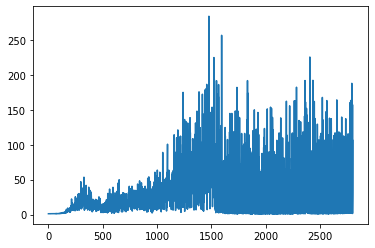

In [238]:
plt.plot(losses);

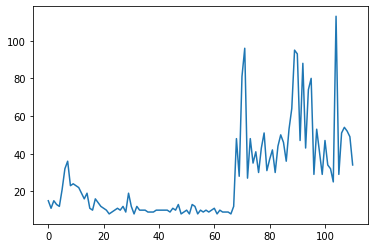

In [239]:
plt.plot(rewards);

Of course, hyperparams should be tuned, target network will improve stability, but you've got the idea :)